In [1]:
import numpy as np
import pandas as pd
import os

#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.5.0


[]

In [2]:
import contextlib
import functools
import time

@contextlib.contextmanager
def timed_execution():
  t0 = time.time()
  yield
  dt = time.time() - t0
  print('Evaluation took: %f seconds' % dt)

def make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad

def np_value(tensor):
  """Get numpy value out of possibly nested tuple of tensors."""
  if isinstance(tensor, tuple):
    return type(tensor)(*(np_value(t) for t in tensor))
  else:
    return tensor.numpy()

def run(optimizer):
  """Run an optimizer and measure it's evaluation time."""
  optimizer()  # Warmup.
  with timed_execution():
    result = optimizer()
  return np_value(result)

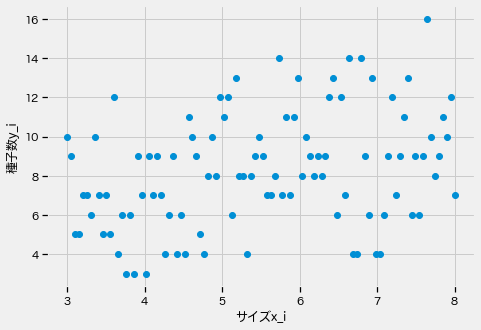

In [3]:
xx = np.linspace(3, 8, 100, dtype=np.float32)

linear_predictor = lambda xx : tf.exp(1.5 + 0.1 * xx)
dist = tfd.Poisson(rate=linear_predictor(xx))
yy = dist.sample(1)

plt.figure(figsize=(6.8, 4.8))
plt.scatter(xx, yy)
plt.xlabel("サイズx_i")
plt.ylabel("種子数y_i")
plt.show()

# GLM

In [4]:
@make_val_and_grad_fn
def logl(beta):
    mean = tf.math.exp(beta[0] + beta[1] * xx)
    dist = tfd.Poisson(rate=mean)
    logl = -tf.reduce_sum(dist.log_prob(yy))
    return logl

dim = 2

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results.converged)
print('Location of the minimum:', results.position) 
print('Number of iterations:', results.num_iterations)

Evaluation took: 0.001886 seconds
L-BFGS Results
From: [-0.36187298 -1.06257541]
Converged: False
Location of the minimum: [-0.36187297 -1.0625755 ]
Number of iterations: 1


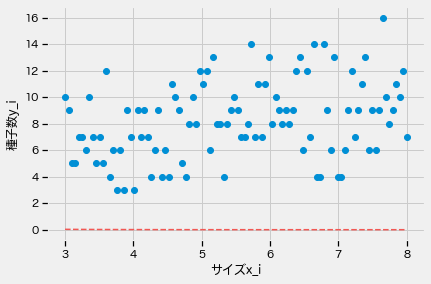

In [5]:
lambdas = np.exp(results.position[0] + results.position[1] * xx)

plt.scatter(xx, yy)
plt.plot(xx, lambdas, color=TFColor[0], linestyle="--")
plt.xlabel("サイズx_i")
plt.ylabel("種子数y_i")
plt.show()

# MCMC



## joint_log_prob function??

TFP performs probabilistic inference by evaluating the model using an unnormalized joint log probability function. The arguments to this joint_log_prob are **data and model state**. The function returns the log of the joint probability that the parameterized model generated the observed data.

[https://github.com/tensorflow/probability/blob/main/discussion/joint_log_prob.md](https://github.com/tensorflow/probability/blob/main/discussion/joint_log_prob.md)

- A prior distribution is an unconditional measure of the likelihood of an input value. It is not parameterized by other input values. Mathematically, a prior probability is written as p(X=x). Each prior distribution measures the likelihood of a single input value. 

- A conditional distribution measures the likelihood of an input value but is parameterized by other input values. Mathematically, a conditional probability is written as p(Y=y|X=x).

For example, returning to our coin flipping example, the unnormalized (heads) posterior log-probability is:

In [6]:
def joint_log_prob(heads, coin_bias):
    """Joint log probability of coin flips under a non-informative prior.

    Args:
      heads: `Tensor` of coin flips; a `0` or `1`.
      coin_bias: `Tensor` of possible coin biases.

    Returns:
      joint_log_prob: The joint log probability measure of given coin flips and
        coin bias.
    """
    rv_coin_bias = tfp.distributions.Uniform(low=0., high=1.)  # Prior
    rv_heads = tfp.distributions.Bernoulli(probs=coin_bias)    # Conditional
    return (rv_coin_bias.log_prob(coin_bias) +
            tf.reduce_sum(rv_heads.log_prob(heads), axis=-1))

In [7]:
unnormalized_posterior_log_prob = lambda coin_bias: joint_log_prob(heads, coin_bias)

Notice that this closure "pins" the joint_log_prob at some value of heads and is only a function of coin_bias.

[要は？]

Contditionalは尤度。尤度はサンプル（実現値）に対して定義される。知りたいのはPriorなので、サンプルは固定する。

## bijector???

- bijection = 全単射 (一対一対応)
- Bijectors encapsulsate the change of variables for a probability density.
- 🤮


## 実装

In [8]:
def joint_log_prob(xx_, yy_, beta1, beta2):
    # prior
    rv_beta1 = tfd.Normal(loc=0., scale=100.)
    rv_beta2 = tfd.Normal(loc=0., scale=100.)

    # conditional
    mean = tf.math.exp(beta1 + beta2 * xx_)
    rv_dist = tfd.Poisson(rate=mean)

    return (
        rv_beta1.log_prob(beta1) +
        rv_beta2.log_prob(beta2) + 
        tf.reduce_sum(rv_dist.log_prob(yy_), axis=-1)
    )

# target_log_prob_fn = lambda *current_state: joint_log_prob(xx, yy, *current_state)

import functools
target_log_prob_fn = functools.partial(joint_log_prob, xx, yy)

In [9]:
# num_chains = 10
# num_iters = 48000 
# num_burnin_steps = 25000 

num_chains = 3
num_iters = 1600 
num_burnin_steps = 1000

hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)

initial_chain_state = [
  tf.zeros(1),
  tf.zeros(1),
]

@tf.function(autograph=False, experimental_compile=True)
def run_chain():
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_iters,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_chain_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [10]:
chains = [run_chain() for i in range(num_chains)]

In [11]:
print("num chain:", len(chains))
print("num param:", len(chains[0]))
print("num iter :", len(chains[0][0]))
print("num data :", len(chains[0][0][0]))
print(chains[0][0][0].numpy(), chains[0][1][0].numpy())

num chain: 3
num param: 2
num iter : 1600
num data : 1
[1.7252347] [0.06929161]


In [12]:
beta1_df = pd.DataFrame([t[0].numpy().flatten() for t in chains])
beta1_df = beta1_df.T.melt(var_name='chain_id', value_name='sample')
beta1_df

,chain_id,sample
0,0,1.725235
1,0,1.717022
2,0,1.709355
3,0,1.723670
4,0,1.723670
...,...,...
4795,2,1.720549
4796,2,1.704318
4797,2,1.779263
4798,2,1.749740


In [13]:
beta2_df = pd.DataFrame([t[1].numpy().flatten() for t in chains])
beta2_df = beta2_df.T.melt(var_name='chain_id', value_name='sample')
beta2_df

,chain_id,sample
0,0,0.069292
1,0,0.064951
2,0,0.066184
3,0,0.070753
4,0,0.070753
...,...,...
4795,2,0.069946
4796,2,0.073216
4797,2,0.054859
4798,2,0.058325


In [14]:
def plot_data(chains):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    for i in range(5):
        chain_samples = chains \
            .query(f'chain_id == {i}') \
            .reset_index(drop=True) \
            ['sample']

        chain_samples_mean = chain_samples.mean()
        chain_samples_std = chain_samples.std()
        chain_samples_plus = chain_samples_mean + 2*chain_samples_std
        chain_samples_minus = chain_samples_mean - 2*chain_samples_std

        sns.distplot(a=chain_samples, color=TFColor[i], hist_kws={'alpha': 0.4}, label=f'chain_{i}', ax=ax[0])
        ax[0].axvline(x=chain_samples_plus, linestyle='--', color=TFColor[i], label=f'chain_{i}_plus = {chain_samples_plus: 0.2f}')
        ax[0].axvline(x=chain_samples_minus, linestyle='--', color=TFColor[i], label=f'chain_{i}_minus = {chain_samples_minus: 0.2f}')
        ax[1].plot(chain_samples, c=TFColor[i], alpha=0.4)
        ax[1].axhline(y=chain_samples_mean, linestyle='--', color=TFColor[i], label=f'chain_{i} mean = {chain_samples_mean: 0.2f}')

    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].set(xlabel='rate', ylabel='')
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[1].set(xlabel='sample', ylabel='rate')
    plt.suptitle('Hamiltonian Monte Carlo Chains', y=0.92);
    plt.show()

/Users/akira/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akira/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akira/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

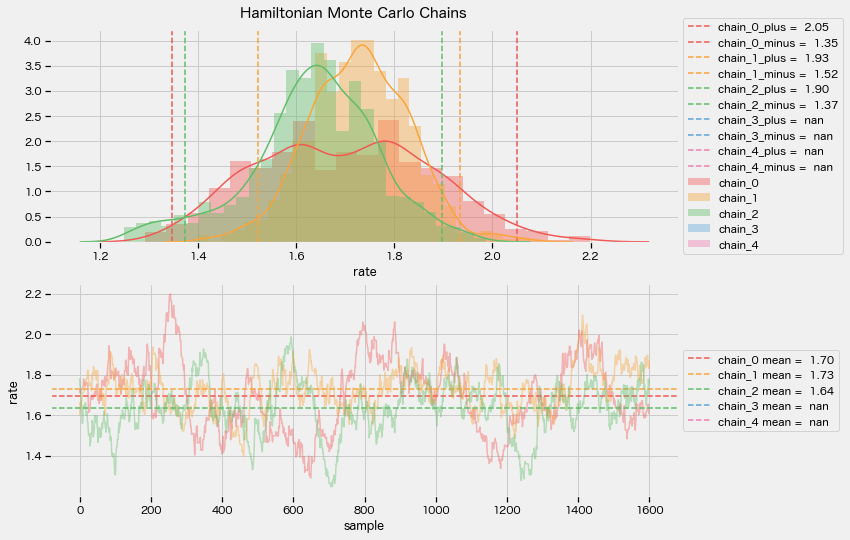

In [15]:
plot_data(beta1_df)

/Users/akira/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akira/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/akira/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

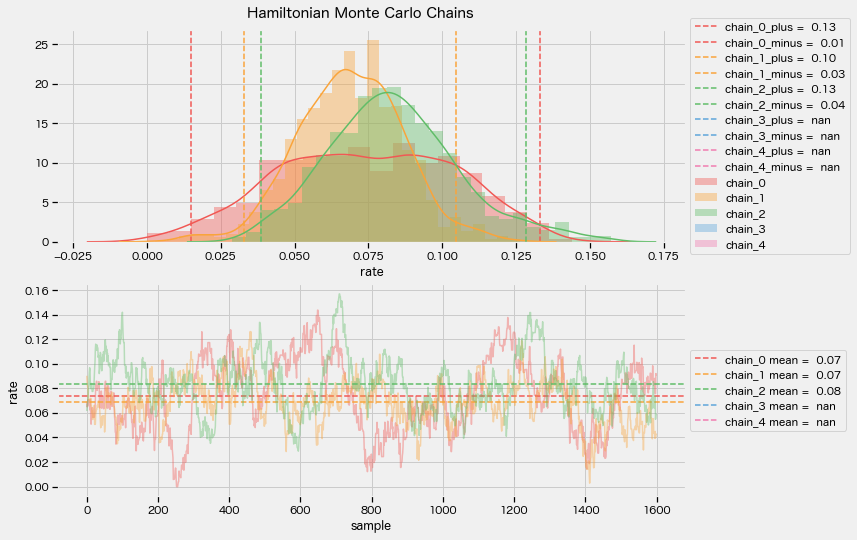

In [16]:
plot_data(beta2_df)

In [17]:
def plot_posterior(chains):
    fig, ax = plt.subplots(2, 1)

    chain_samples = chains['sample']
    chain_samples_mean = chain_samples.mean()
    chain_samples_std = chain_samples.std()
    chain_samples_plus = chain_samples_mean + 2*chain_samples_std
    chain_samples_minus = chain_samples_mean - 2*chain_samples_std

    sns.distplot(a=chain_samples, color=TFColor[9], label=f'chains samples', ax=ax[0])
    ax[0].axvline(x=chain_samples_plus, linestyle='--', color=TFColor[4], label=f'$\mu + 2\sigma$ = {chain_samples_plus: 0.2f}')
    ax[0].axvline(x=chain_samples_minus, linestyle='--', color=TFColor[4], label=f'$\mu - 2\sigma$ = {chain_samples_minus: 0.2f}')
    ax[1].plot(chain_samples, c=TFColor[9], alpha=0.7)
    ax[1].axhline(y=chain_samples_mean, linestyle='--', color=TFColor[0], label=f'$\mu$ = {chain_samples_mean: 0.2f}')

    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.suptitle(f'Posterior Distribution (Rate)', y=0.92);
    plt.show()

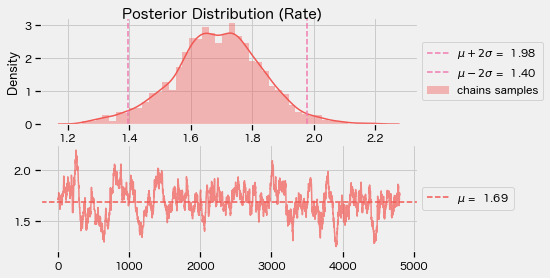

In [18]:
plot_posterior(beta1_df)

/Users/akira/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


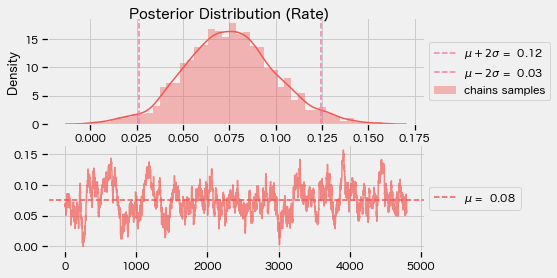

In [19]:
plot_posterior(beta2_df)

In [20]:
rdm_idx = np.random.choice(beta1_df.shape[0], 1500)
betas = list(zip(beta1_df["sample"][rdm_idx], beta2_df["sample"][rdm_idx]))
lambdas = [tf.exp(beta[0] + beta[1] * xx) for beta in betas]

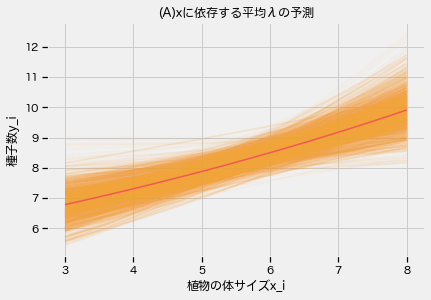

In [21]:
for lambda_ in lambdas:
    plt.plot(xx, lambda_, color=TFColor[1], alpha=0.05)
plt.plot(xx, tnp.mean(lambdas, axis=0), color=TFColor[0])
plt.xlabel("植物の体サイズx_i")
plt.ylabel("種子数y_i")
plt.title("(A)xに依存する平均λの予測")
plt.show()

In [22]:
for beta in betas:
    plt.scatter(beta[0], beta[1], color=TFColor[2], alpha=0.1)
plt.xlabel("切片β_1")
plt.ylabel("傾きβ_2")
plt.title("(B)事後分布p(β_1,β_2|Y")
plt.show()